## Dataset Creation and Cleansing


2025-01-14 15:58:40.043872: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:src.llm_dataset_filler:Total rows with missing values: 14



Full Merged Dataset:
   id   Age  Gender Education Level          Job Title  Years of Experience  \
0   0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1   1  28.0  Female        Master's       Data Analyst                  3.0   
2   2  45.0    Male             PhD     Senior Manager                 15.0   
3   3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4   4  52.0    Male        Master's           Director                 20.0   

                                         Description    Salary  
0  I am a 32-year-old male working as a Software ...   90000.0  
1  I am a 28-year-old data analyst with a Master'...   65000.0  
2  I am a 45-year-old Senior Manager with a PhD a...  150000.0  
3  I am a 36-year-old female Sales Associate with...   60000.0  
4  I am a 52-year-old male with over two decades ...  200000.0  
      id   Age  Gender Education Level                      Job Title  \
370  370  35.0  Female      Bachelor's  

DEBUG:src.llm_dataset_filler:Index 235: Received NDJSON response for Gender.
DEBUG:src.llm_dataset_filler:Index 235: Inferred Gender: Male
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 332: Received NDJSON response for Job Title.
DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Salary.
DEBUG:src.llm_dataset_filler:Index 172: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 172: Inferred Job Title: Not found
DEBUG:src.llm_dataset_filler:Index 260: Inferred Salary: Not found
DEBUG:src.llm_dataset_filler:Index 332: Inferred Job Title: Senior UX Designer
DEBUG:src.llm_dataset_filler:Index 172: Inferred Age: Not found
DEBUG:src.llm_dataset_filler:Index 260: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 139: Received NDJSON response for Education Level.
DEBUG:src.llm_dataset_filler:Index 287: Received NDJSON response for Age.
DEBUG:src.llm_dataset_filler:Index 2


Missing Values in Full Dataset:
id                     0
Age                    3
Gender                 3
Education Level        2
Job Title              2
Years of Experience    2
Description            3
Salary                 2
dtype: int64

Rows with Missing Values:
      id   Age Gender Education Level                 Job Title  \
111  111  37.0   Male      Bachelor's  Software Project Manager   
125  125  26.0   Male      Bachelor's         Junior Accountant   
172  172   NaN    NaN             NaN                       NaN   
177  177  31.0   Male      Bachelor's         Junior Accountant   
225  225  40.0    NaN      Bachelor's  Senior Marketing Manager   
260  260   NaN    NaN             NaN                       NaN   
315  315   NaN   Male      Bachelor's  Senior Software Engineer   

     Years of Experience                                        Description  \
111                  9.0                                                NaN   
125                  2.0        

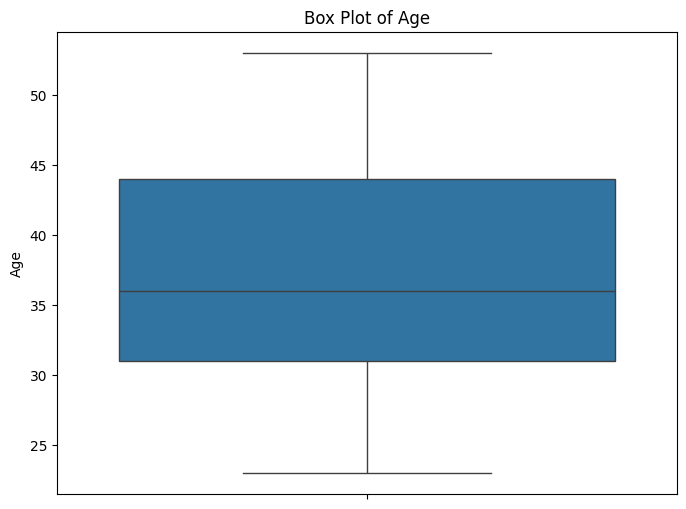

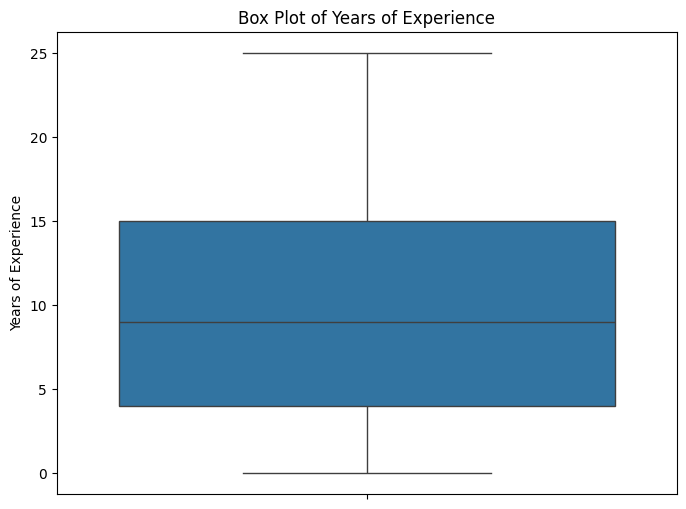

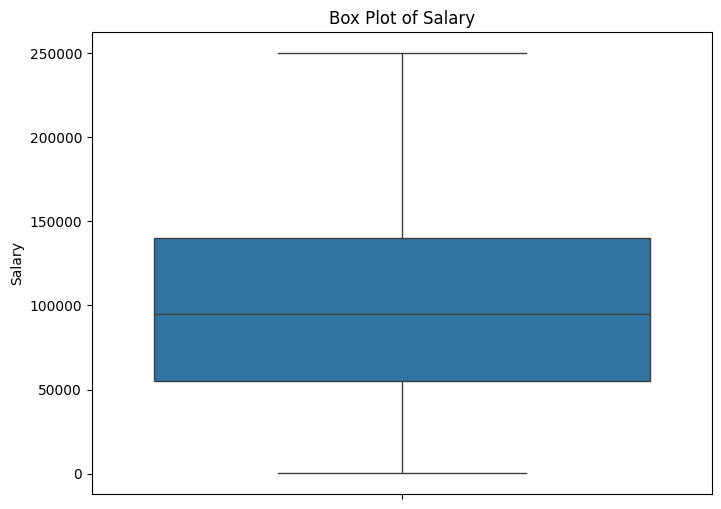

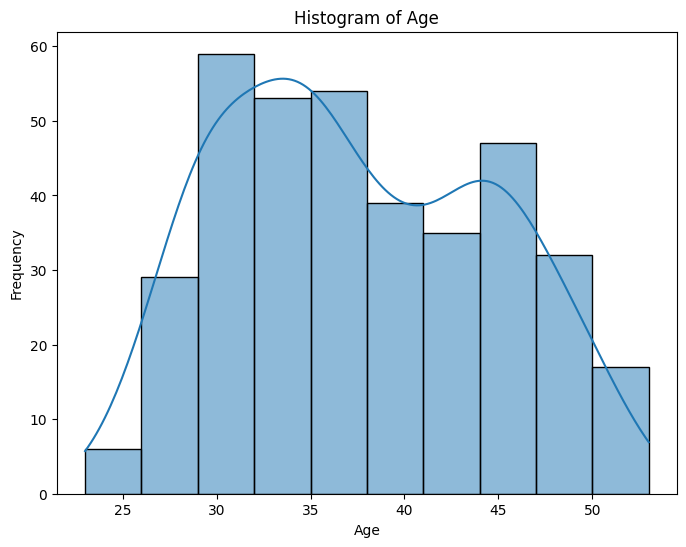

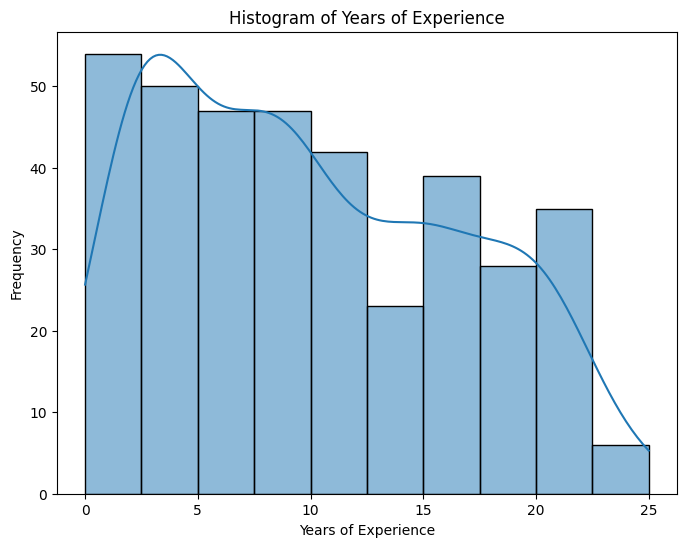

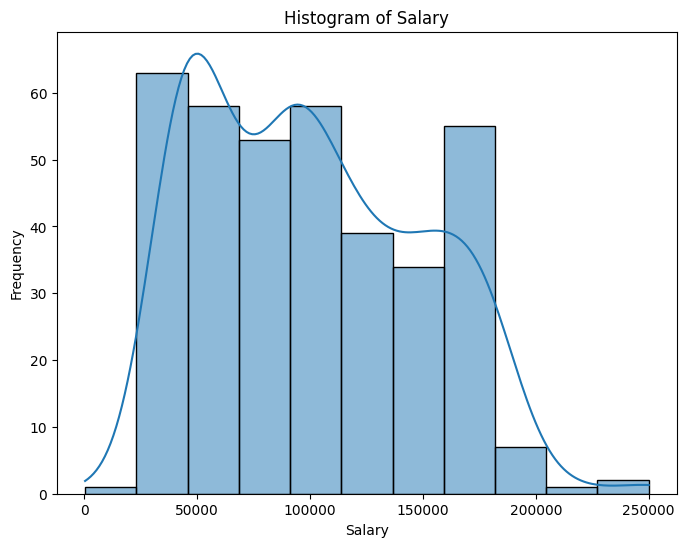

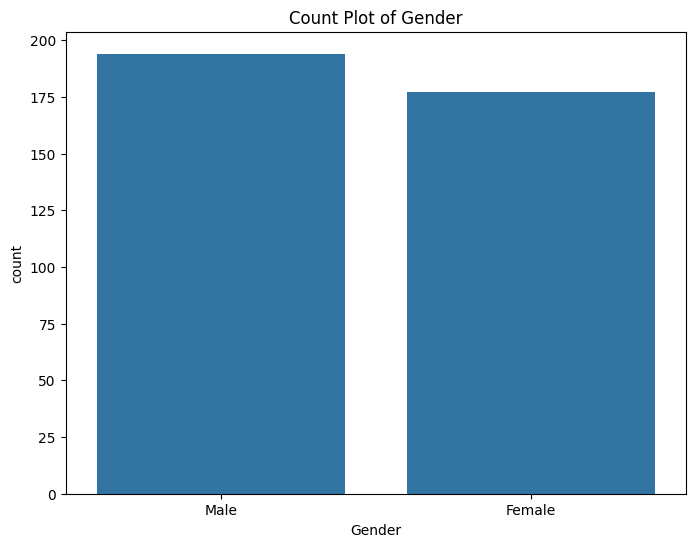

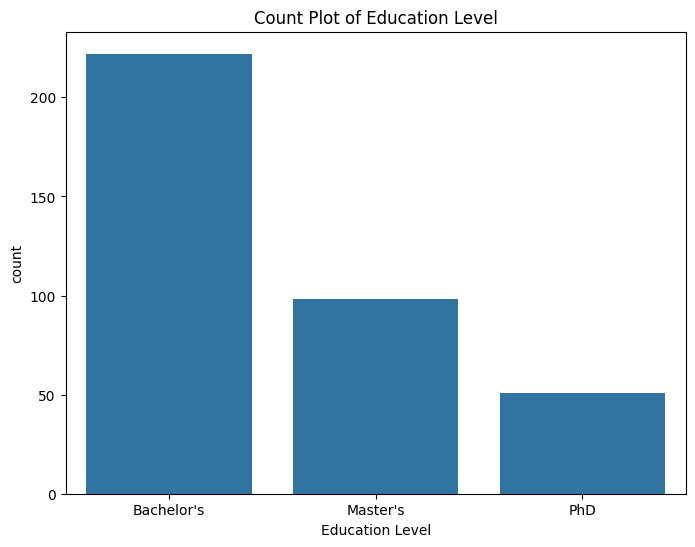

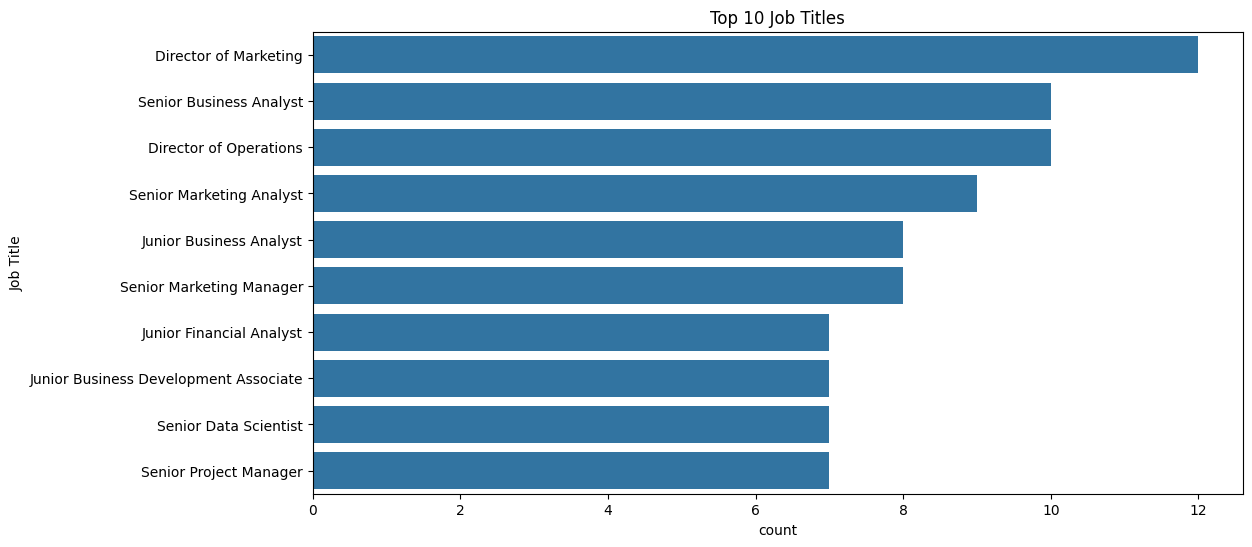

Scaler saved to ./models/scaler.pkl
Target encoder saved to ./models/target_encoder.pkl
Job title mapping saved to ./models/job_title_mapping.pkl
Scaler saved to ./models/nn_scaler.pkl
Target encoder saved to ./models/nn_target_encoder.pkl
Job title mapping saved to ./models/nn_job_title_mapping.pkl


In [1]:
import matplotlib.font_manager as fm
import logging
from sklearn.preprocessing import MinMaxScaler, StandardScaler

fm._log.setLevel(logging.WARNING)
from src import data_loading
from src import preprocessing
from src import visualize_data
from src import feature_engenieering
from src import modeling
from src import evaluation
from src import model_compare




#files path for the raw dataset:
data_files = ['./data/people.csv','./data/descriptions.csv','./data/salary.csv',]

#merge datasets in a cohesive Dataframe
full_dataset = data_loading.load_data(data_files)

#preprocessing of the dataframe adds missing values with LLM inference over descriptions of each row, drops the incomplete rows and cleans up the data.
cleansed_dataset = await preprocessing.preprocess(full_dataset)

visualize_data.visualize_dataset(cleansed_dataset)

#split the dataset into an 80 / 20 ratio for training and testing.
X_train, X_test, y_train, y_test = feature_engenieering.split_data(cleansed_dataset)


#normalize and scale the datasets using MinMaxScaler and target encoder for random forest

normalized_X_train, te, scaler = feature_engenieering.normalize_train_data(X_train, y_train,MinMaxScaler())

normalized_X_test = feature_engenieering.normalize_test_data(X_test, te, scaler)



#normalize and scale the datasets using MinMaxScaler and target encoder for Neural Networks

normalized_X_train_nn, te_nn, scaler_nn = feature_engenieering.normalize_train_data(X_train, y_train,StandardScaler(),"nn_")

normalized_X_test_nn = feature_engenieering.normalize_test_data(X_test, te_nn, scaler_nn)





### Dummy Regressor Baseline model training

With the datasets created we use the train with MinMaxScaling dataset splits in a script to create a Random Forest Regressor using the scikit-learn framework.

We traing a Dummy Reggressor to use as a baseline for model performance comparison and then train a Random Forest Regressor algorithm with hyperparameter tuning. We also evaluate the trained model by calculating metrics such as mean absolute error (MAE), root mean squared error (RMSE) and R-squared e (R2) and plot a scatterplot of predicted vs actual salaries.

In [2]:
dummy = modeling.train_dummy_regressor(normalized_X_train, y_train)

Dummy Regressor saved as: ./models/dummy_reggresor_model.pkl


### Random Forest Regressor training and evaluation

In [3]:
#train a model using a random forest regressor algorithm and print out the predictions for the normalized test data.


rf_model = modeling.train_model(normalized_X_train, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_

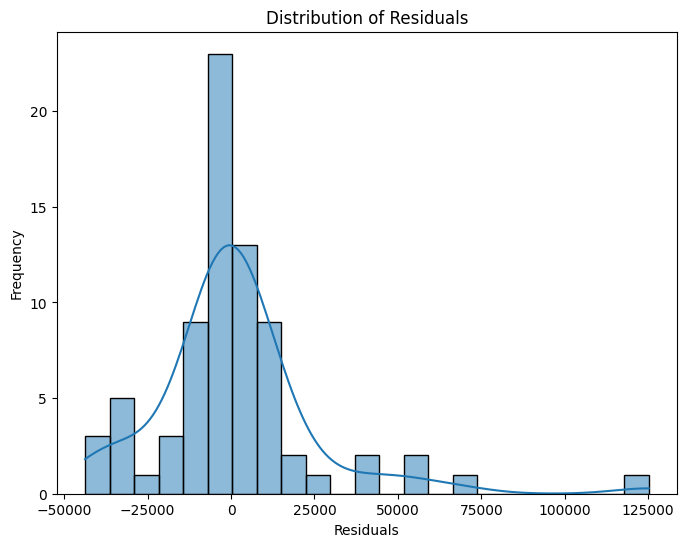

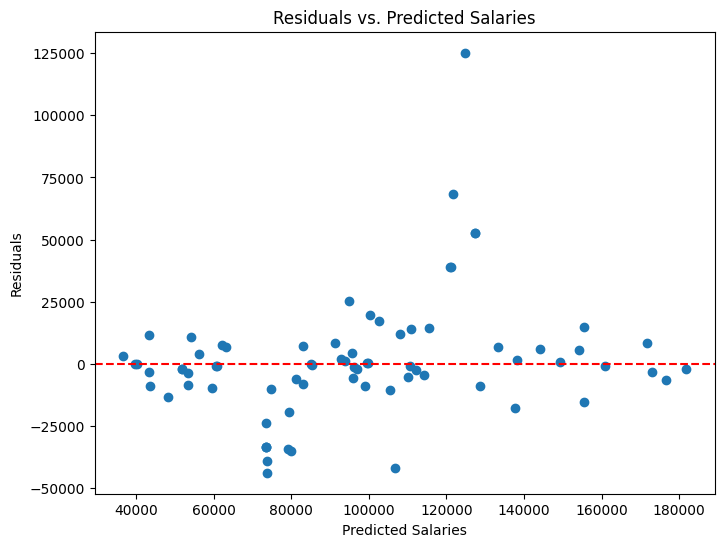

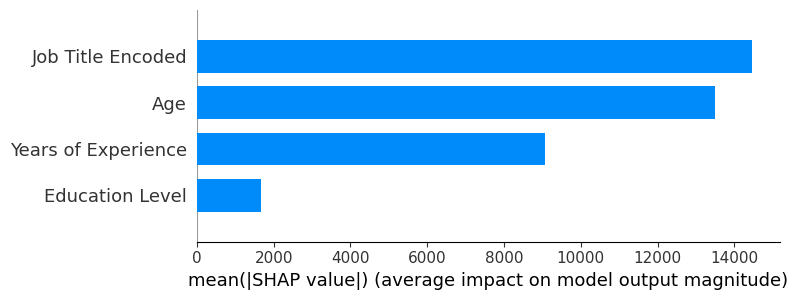

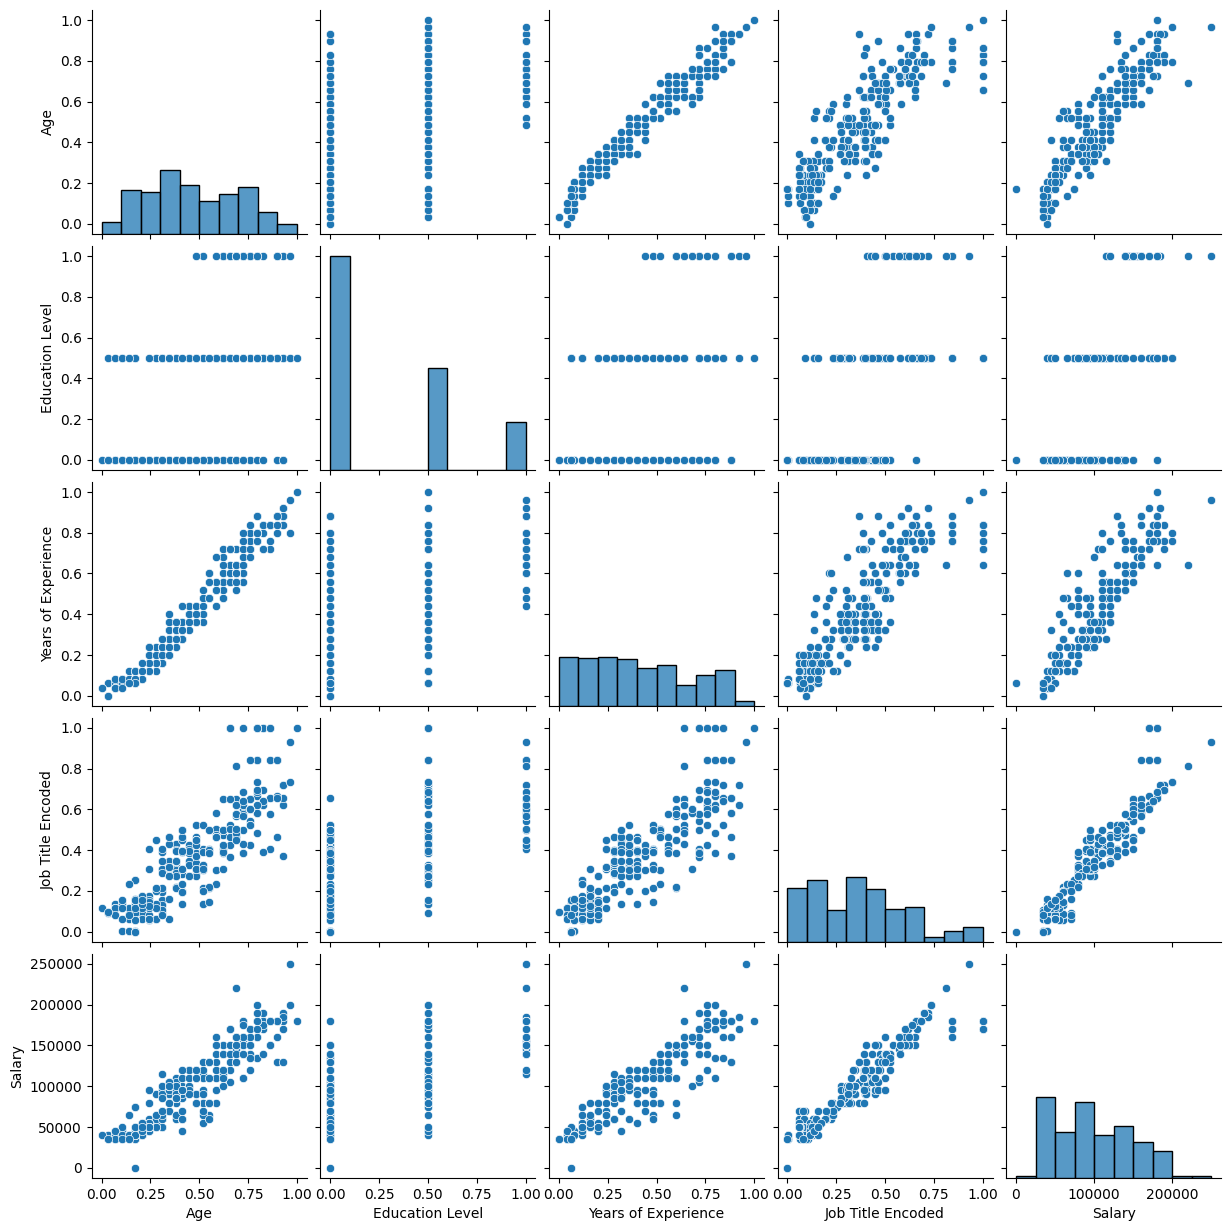

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x772aaa53aff0>


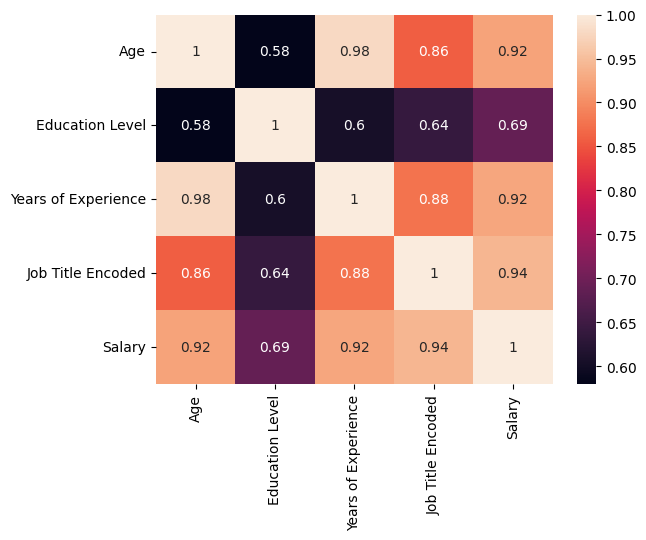

Random Forest Regressor Performance After Hyperparameter Tuning:
Mean Squared Error (MSE): 602275408.43
Mean Absolute Error (MAE): 14683.52
R-squared Score (R²): 0.75


{'mse': 602275408.432204,
 'mae': 14683.524987247132,
 'r2': 0.7481592777042222,
 'predictions': array([115576.43217893, 106798.87806638, 110989.46428571,  43394.5540293 ,
        133222.55772006,  36632.56578977, 121134.16666667, 108041.01190476,
        128700.87301587, 105404.27489177,  53507.93205161, 121035.        ,
         73847.12301587,  93948.1547619 , 112245.05952381,  96246.42857143,
         82955.41666667,  85407.6461039 ,  62183.47222222,  97001.28968254,
        114321.94083694, 110208.47402597, 121822.61904762,  94851.15079365,
         92838.71753247,  59601.98412698,  63132.99603175,  39865.67460317,
        100260.35714286, 173071.07142857,  79247.89055973,  99583.69047619,
         79450.03341688, 144045.00763126, 181852.73809524,  43692.5       ,
        171616.05042017,  73641.37942613, 155393.21428571,  53529.26141669,
        110714.02597403, 127465.71428571, 124813.92857143, 176477.57936508,
         73537.12301587, 138273.58946609, 102577.38095238,  74879.08

In [4]:
#use the test dataset to predict salaries based on the trained model for a first fast evaluation.

evaluation.evaluate_model(normalized_X_test, y_test, normalized_X_train,y_train, rf_model)

Next we use Confidence intervals to further test the  models performance using bootstraping 

In [5]:
evaluation.calculate_metrics(normalized_X_test, y_test, rf_model)

Model Performance with Confidence Intervals:
Mean Squared Error (MSE): 594554170.21 (95% CI: [293654845.28, 1009253566.56])
Mean Absolute Error (MAE): 14596.17 (95% CI: [11083.21, 18511.06])
R-squared Score (R²): 0.75 (95% CI: [0.63, 0.86])


{'mse': {'mean': 594554170.2127341,
  'ci_lower': 293654845.2847966,
  'ci_upper': 1009253566.5553329},
 'mae': {'mean': 14596.174209022895,
  'ci_lower': 11083.211324209753,
  'ci_upper': 18511.058102458086},
 'r2': {'mean': 0.753282609935937,
  'ci_lower': 0.6279515189690166,
  'ci_upper': 0.859630614403016}}

### Random Forest feature selection process.



I choose the Random Forest Reggresor to be able to catch non linear relationships better with realtively low data quantity for training, the model is Hyperparametrized using a grid approach and the best model is selected for testing.

In the process of selecting features for the Random Forest Regressor model, based on correlation and feature importance analysis after the first "naive" model was trained in the normalized data as is to gather more information on the relationships and model error R-squared Score (R²).

it is also quite notable that the heteroscedasticity present in the middle of the distribution seems to be caused by the dataset itself, most possibly by the lack of examples to fill the distribution appropiately, otherwise the distribution of residuals seems to be acceptable considering there are no statiscally significant outliers in the dataset.

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 866064920.96
        Mean Absolute Error (MAE): 17982.33
        R-squared Score (R²): 0.65
        
![img](./plots/residuals_distribution.png)
![Feature Importance](./plots/feature_importance.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap.png)



It can be seen now better results by droping geneder since it has a really low correlation with salary and importance , and lower the smoothing for the encoded job titles to 3 (10 was the previous value).

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 600148032.12
        Mean Absolute Error (MAE): 14748.68
        R-squared Score (R²): 0.76

![img](./plots/residuals_distribution_2.png)
![Feature Importance](./plots/feature_importance_2.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap_2.png)

        
next feature to remove, surprinsingly is education level wich has a low correlation with salary, but if pruned from the dataset the model shows performs worst than before with the same hyperparametrization.

        Random Forest Regressor Performance After Hyperparameter Tuning:
        Mean Squared Error (MSE): 808374516.33
        Mean Absolute Error (MAE): 17240.95
        R-squared Score (R²): 0.67

![img](./plots/residuals_distribution_3.png)
![Feature Importance](./plots/feature_importance_3.png)
![feature correlation heatmap](./plots/feature_correlation_heatmap_3.png)



### Neural Network training and evaluation

in this step we create a second model to test performance of different approaches in this specific problem. I'm using the same dataset and features as the random forest regressor but normalized using the stardad scaling between -1 and 1 wich provides better performances on NN sequiential models

In [6]:
nn_model = modeling.train_NN_model(normalized_X_train_nn,y_train)

2025-01-14 15:59:24.449868: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-14 15:59:26.895328: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-14 15:59:26.895407: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-14 15:59:26.896376: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-14 15:59:26.896481: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

Epoch 1/1000


I0000 00:00:1736881168.837728  447962 service.cc:146] XLA service 0x772870004d00 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736881168.837767  447962 service.cc:154]   StreamExecutor device (0): AMD Radeon RX 6900 XT, AMDGPU ISA version: gfx1030
2025-01-14 15:59:28.882238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - loss: 11542185984.0000

I0000 00:00:1736881172.001332  447962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 513ms/step - loss: 12266021888.0000 - val_loss: 14909927424.0000
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11376238592.0000 - val_loss: 14909688832.0000
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12499177472.0000 - val_loss: 14909051904.0000
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12857554944.0000 - val_loss: 14907365376.0000
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11829435392.0000 - val_loss: 14903122944.0000
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12482105344.0000 - val_loss: 14893149184.0000
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11924084736.0000 - val_loss: 14870807552.0000
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12738979840.0000 - val_loss: 14823412736.0000
Epoch 9/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11391908864.0000 - val_loss: 14729662464.0000
Epoch 10/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12220538880.0000

DEBUG:h5py._conv:Creating converter from 5 to 3


Training loss plot saved to ./plots/nn_training_loss.png
Neural Network model saved to ./models/neural_network_model.keras


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


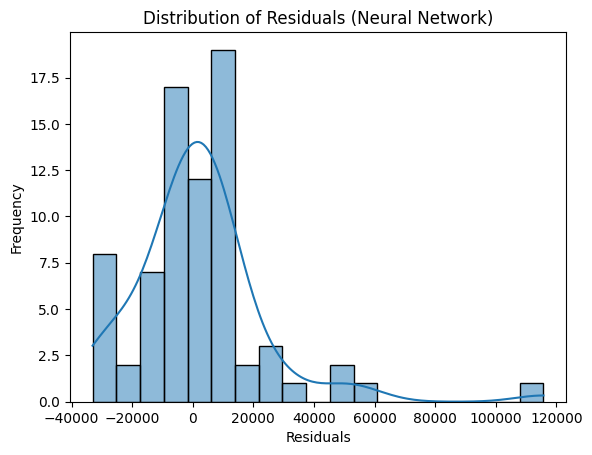

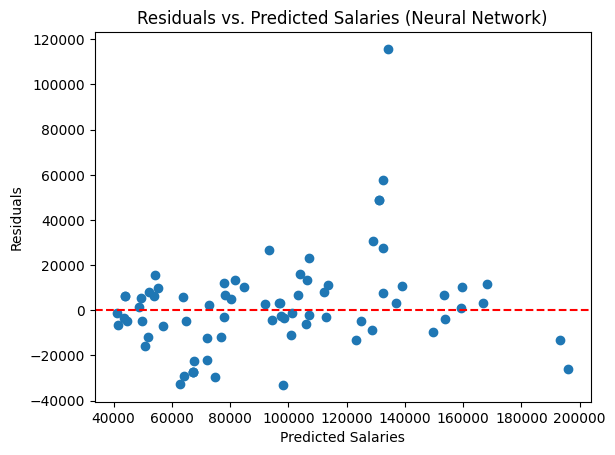

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  0%|          | 0/75 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 5726.797265624997
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 11132.807708333334
DEBUG:shap:self.fx = 106932.8671875
DEBUG:shap:self.link(self.fx) = 106932.8671875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ 7732.20164063, -3514.21280382,  1508.80842882,  5406.01044271])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 2126.114999999996
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 2261.4092708333337
DEBUG:shap:self.fx = 98061.46875
DEBUG:shap:self.link(self.fx) = 98061.46875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ 5279.01986111, -3704.70486111,   551.8       ,   135.29427083])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 17932.914765625
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 17849.424895833334
DEBUG:shap:self.fx = 113649.484375
DEBUG:shap:self.link(self.fx) = 113649.484375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([17624.80427951, -3371.48782118,  3679.59830729,   -83.48986979])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -24778.36585937501
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -43856.196197916666
DEBUG:shap:self.fx = 51943.86328125
DEBUG:shap:self.link(self.fx) = 51943.86328125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-16601.05471354,  -5207.10369792,  -2970.20744792, -19077.83033854])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 31786.467899305557
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 36754.237395833334
DEBUG:shap:self.fx = 132554.296875
DEBUG:shap:self.link(self.fx) = 132554.296875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([13690.52746528, 16377.49831597,  1718.44211806,  4967.76949653])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -27529.700468749998
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -52278.317291666666
DEBUG:shap:self.fx = 43521.7421875
DEBUG:shap:self.link(self.fx) = 43521.7421875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-18644.40958333,  -5409.40039931,  -3475.89048611, -24748.61682292])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 36896.807204861114
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 36650.268645833334
DEBUG:shap:self.fx = 132450.328125
DEBUG:shap:self.link(self.fx) = 132450.328125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([32431.69211806, -3339.90163194,  7805.01671875,  -246.53855903])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -3347.283472222217
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 8333.776458333334
DEBUG:shap:self.fx = 104133.8359375
DEBUG:shap:self.link(self.fx) = 104133.8359375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-5173.49211806,  1809.55362847,    16.65501736, 11681.05993056])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 11117.575269097219
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 28986.979583333334
DEBUG:shap:self.fx = 124787.0390625
DEBUG:shap:self.link(self.fx) = 124787.0390625
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([13072.51584201, -3387.42235243,  1432.48177951, 17869.40431424])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 1359.3727343750038
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 1518.0577083333337
DEBUG:shap:self.fx = 97318.1171875
DEBUG:shap:self.link(self.fx) = 97318.1171875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-187.14877604, 1843.13514757, -296.61363715,  158.68497396])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -19550.018098958335
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -46158.336822916666
DEBUG:shap:self.fx = 49641.72265625
DEBUG:shap:self.link(self.fx) = 49641.72265625
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-11978.78188368,  -4957.01784722,  -2614.21836806, -26608.31872396])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 33591.07987847223
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 33365.073333333334
DEBUG:shap:self.fx = 129165.1328125
DEBUG:shap:self.link(self.fx) = 129165.1328125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([29919.78993056, -3347.19039931,  7018.48034722,  -226.00654514])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -31910.497161458334
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -31634.391510416666
DEBUG:shap:self.fx = 64165.66796875
DEBUG:shap:self.link(self.fx) = 64165.66796875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-23897.999375  ,  -4991.25450521,  -3021.24328125,    276.10565104])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -6344.774444444437
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -10941.348541666666
DEBUG:shap:self.fx = 84858.7109375
DEBUG:shap:self.link(self.fx) = 84858.7109375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-2414.52236111, -3936.18225694,     5.93017361, -4596.57409722])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 17045.352013888896
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 17027.838958333334
DEBUG:shap:self.fx = 112827.8984375
DEBUG:shap:self.link(self.fx) = 112827.8984375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ 1.80071702e+04, -3.43487276e+03,  2.47305460e+03, -1.75130556e+01])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 7710.037777777776
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 2566.1905208333337
DEBUG:shap:self.fx = 98366.25
DEBUG:shap:self.link(self.fx) = 98366.25
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([10405.46498264, -3664.38527778,   968.95807292, -5143.84725694])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -18266.70306423611
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -17956.278229166666
DEBUG:shap:self.fx = 77843.78125
DEBUG:shap:self.link(self.fx) = 77843.78125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-12154.89841146,  -4447.14174479,  -1664.66290799,    310.42483507])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -9462.333906250005
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -15589.465729166666
DEBUG:shap:self.fx = 80210.59375
DEBUG:shap:self.link(self.fx) = 80210.59375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-4882.33215278, -4073.49710069,  -506.50465278, -6127.13182292])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -16584.706614583338
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -41452.942291666666
DEBUG:shap:self.fx = 54347.1171875
DEBUG:shap:self.link(self.fx) = 54347.1171875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ -9741.79951389,  -4708.42662326,  -2134.48047743, -24868.23567708])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -3924.710425347213
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -3779.1922916666663
DEBUG:shap:self.fx = 92020.8671875
DEBUG:shap:self.link(self.fx) = 92020.8671875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-5201.47591146,  1918.96710938,  -642.20162326,   145.51813368])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 20423.471996527776
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 27331.799895833334
DEBUG:shap:self.fx = 123131.859375
DEBUG:shap:self.link(self.fx) = 123131.859375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ 1721.505625  , 18762.78017361,   -60.81380208,  6908.32789931])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 1358.580138888894
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 11383.870208333334
DEBUG:shap:self.fx = 107183.9296875
DEBUG:shap:self.link(self.fx) = 107183.9296875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ -187.52666667,  1824.00321181,  -277.89640625, 10025.29006944])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 36782.54183159723
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 36578.909270833334
DEBUG:shap:self.fx = 132378.96875
DEBUG:shap:self.link(self.fx) = 132378.96875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([18788.40872396, 16638.78408854,  1355.3490191 ,  -203.63256076])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 2027.0217621527763
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -2294.6297916666663
DEBUG:shap:self.fx = 93505.4296875
DEBUG:shap:self.link(self.fx) = 93505.4296875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ 5262.85638021, -3758.40832465,   522.5737066 , -4321.65155382])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -8981.716875000002
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -14003.348541666666
DEBUG:shap:self.fx = 81796.7109375
DEBUG:shap:self.link(self.fx) = 81796.7109375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-4940.94102431, -3990.32385417,   -50.45199653, -5021.63166667])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -24073.14398003472
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -38920.743072916666
DEBUG:shap:self.fx = 56879.31640625
DEBUG:shap:self.link(self.fx) = 56879.31640625
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-16552.42890191,  -4928.67303385,  -2592.04204427, -14847.59909288])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -16220.43059461806
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -31897.981354166666
DEBUG:shap:self.fx = 63902.078125
DEBUG:shap:self.link(self.fx) = 63902.078125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ -9741.36629774,  -4624.48878038,  -1854.57551649, -15677.55075955])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -29838.152447916662
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -54544.067291666666
DEBUG:shap:self.fx = 41255.9921875
DEBUG:shap:self.link(self.fx) = 41255.9921875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-20541.41302083,  -5447.06309896,  -3849.67632813, -24705.91484375])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 10525.287439236115
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 10640.628020833334
DEBUG:shap:self.fx = 106440.6875
DEBUG:shap:self.link(self.fx) = 106440.6875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([7498.29934896, 1724.23646701, 1302.75162326,  115.3405816 ])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 20762.40258680557
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 71016.67489583333
DEBUG:shap:self.fx = 166816.734375
DEBUG:shap:self.link(self.fx) = 166816.734375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([15010.94564236,  1275.56769097,  4475.88925347, 50254.27230903])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -28578.744748263893
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -28264.551666666666
DEBUG:shap:self.fx = 67535.5078125
DEBUG:shap:self.link(self.fx) = 67535.5078125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-20861.29743924,  -4895.31919271,  -2822.12811632,    314.1930816 ])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 13437.981076388885
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 5498.643645833334
DEBUG:shap:self.fx = 101298.703125
DEBUG:shap:self.link(self.fx) = 101298.703125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ 9990.41965278,  1687.03463542,  1760.52678819, -7939.33743056])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -23929.818532986115
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -23621.465729166666
DEBUG:shap:self.fx = 72178.59375
DEBUG:shap:self.link(self.fx) = 72178.59375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-16722.91224826,  -4771.20502604,  -2435.70125868,    308.35280382])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 33923.525486111124
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 43244.128020833334
DEBUG:shap:self.fx = 139044.1875
DEBUG:shap:self.link(self.fx) = 139044.1875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([16441.1409375 , 16543.09642361,   939.288125  ,  9320.60253472])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 48668.28923611112
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 97518.51864583333
DEBUG:shap:self.fx = 193318.578125
DEBUG:shap:self.link(self.fx) = 193318.578125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([30039.00611111, 14716.93907986,  3912.34404514, 48850.22940972])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -36148.233194444445
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -54435.219635416666
DEBUG:shap:self.fx = 41364.83984375
DEBUG:shap:self.link(self.fx) = 41364.83984375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-26438.92362847,  -5396.13315972,  -4313.17640625, -18286.98644097])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 43359.20478298611
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 72457.26864583333
DEBUG:shap:self.fx = 168257.328125
DEBUG:shap:self.link(self.fx) = 168257.328125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([24538.39341146, 14970.87238715,  3849.93898438, 29098.06386285])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -24088.127942708332
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -23795.442291666666
DEBUG:shap:self.fx = 72004.6171875
DEBUG:shap:self.link(self.fx) = 72004.6171875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-16713.80294271,  -4864.88813368,  -2509.43686632,    292.68565104])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 31820.891736111113
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 53737.768645833334
DEBUG:shap:self.fx = 149537.828125
DEBUG:shap:self.link(self.fx) = 149537.828125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([13988.01666667, 15690.70467014,  2142.17039931, 21916.87690972])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -22003.68118923612
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -47160.110260416666
DEBUG:shap:self.fx = 48639.94921875
DEBUG:shap:self.link(self.fx) = 48639.94921875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-14269.7794184 ,  -4989.54119792,  -2744.36057292, -25156.42907118])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 3960.7912413194526
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 7578.753020833334
DEBUG:shap:self.fx = 103378.8125
DEBUG:shap:self.link(self.fx) = 103378.8125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([2380.94749132, 1845.30162326, -265.45787326, 3617.96177951])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 35410.59208333334
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 35316.940520833334
DEBUG:shap:self.fx = 131117.0
DEBUG:shap:self.link(self.fx) = 131117.0
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([28530.76164931,  1580.53857639,  5299.29185764,   -93.6515625 ])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 38782.165555555555
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 38456.893645833334
DEBUG:shap:self.fx = 134256.953125
DEBUG:shap:self.link(self.fx) = 134256.953125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([31586.31668403, -3273.47991319, 10469.32878472,  -325.27190972])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 34008.576987847235
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 100219.69052083333
DEBUG:shap:self.fx = 196019.75
DEBUG:shap:self.link(self.fx) = 196019.75
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([28340.22766493,  1281.81509549,  4386.53422743, 66211.11353299])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -28783.99620659722
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -28482.371979166666
DEBUG:shap:self.fx = 67317.6875
DEBUG:shap:self.link(self.fx) = 67317.6875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-20875.35858507,  -4989.60344618,  -2919.03417535,    301.62422743])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 34107.845642361106
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 41010.237395833334
DEBUG:shap:self.fx = 136810.296875
DEBUG:shap:self.link(self.fx) = 136810.296875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([16360.93029514, 16426.07916667,  1320.83618056,  6902.39175347])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 16501.393489583337
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 16304.979583333334
DEBUG:shap:self.fx = 112105.0390625
DEBUG:shap:self.link(self.fx) = 112105.0390625
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-2965.85503472, 19365.71078125,   101.53774306,  -196.41390625])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -18836.906093749996
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -18804.223541666666
DEBUG:shap:self.fx = 76995.8359375
DEBUG:shap:self.link(self.fx) = 76995.8359375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-21577.8378559 ,   3426.78583333,   -685.85407118,     32.68255208])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -27356.400759548615
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -46408.926666666666
DEBUG:shap:self.fx = 49391.1328125
DEBUG:shap:self.link(self.fx) = 49391.1328125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-18745.05543837,  -5316.50846788,  -3294.8368533 , -19052.52590712])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -28783.99620659722
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -28482.371979166666
DEBUG:shap:self.fx = 67317.6875
DEBUG:shap:self.link(self.fx) = 67317.6875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-20875.35858507,  -4989.60344618,  -2919.03417535,    301.62422743])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -29518.190529513893
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -44984.563385416666
DEBUG:shap:self.fx = 50815.49609375
DEBUG:shap:self.link(self.fx) = 50815.49609375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-20743.36415799,  -5403.92875   ,  -3370.89762153, -15466.3728559 ])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -11765.198281249994
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -1535.3407291666663
DEBUG:shap:self.fx = 94264.71875
DEBUG:shap:self.link(self.fx) = 94264.71875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-7395.52102431, -3931.05126736,  -438.62598958, 10229.85755208])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -19344.650407986115
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -40572.305572916666
DEBUG:shap:self.fx = 55227.75390625
DEBUG:shap:self.link(self.fx) = 55227.75390625
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-12082.46014757,  -4864.90595486,  -2397.28430556, -21227.65516493])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 5526.679062499997
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 1196.7608333333337
DEBUG:shap:self.fx = 96996.8203125
DEBUG:shap:self.link(self.fx) = 96996.8203125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ 7659.54868056, -3621.90401042,  1489.03439236, -4329.91822917])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 36131.52074652777
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 58078.112395833334
DEBUG:shap:self.fx = 153878.171875
DEBUG:shap:self.link(self.fx) = 153878.171875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([19161.32998264, 16066.954375  ,   903.23638889, 21946.59164931])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 36402.226640625
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 57567.049895833334
DEBUG:shap:self.fx = 153367.109375
DEBUG:shap:self.link(self.fx) = 153367.109375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([19174.3583941 , 15912.62552951,  1315.24271701, 21164.82325521])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 49681.42590277778
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 63925.878020833334
DEBUG:shap:self.fx = 159725.9375
DEBUG:shap:self.link(self.fx) = 159725.9375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([39367.63744792,  1440.20602431,  8873.58243056, 14244.45211806])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -7905.014908854158
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -30890.059479166666
DEBUG:shap:self.fx = 64910.0
DEBUG:shap:self.link(self.fx) = 64910.0
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ -2413.16450087,  -4330.39378906,  -1161.45661892, -22985.04457031])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -21938.019292534726
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -51939.364166666666
DEBUG:shap:self.fx = 43860.6953125
DEBUG:shap:self.link(self.fx) = 43860.6953125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-14054.79233073,  -4955.84289497,  -2927.38406684, -30001.34487413])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -10540.531059027768
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 1025.9717708333337
DEBUG:shap:self.fx = 96826.03125
DEBUG:shap:self.link(self.fx) = 96826.03125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-12081.00201389,   2392.83423611,   -852.36328125,  11566.50282986])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 10111.243012152781
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 10250.565520833334
DEBUG:shap:self.fx = 106050.625
DEBUG:shap:self.link(self.fx) = 106050.625
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([7522.06747396, 1749.8474566 ,  839.3280816 ,  139.32250868])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -16773.382747395837
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -41964.008697916666
DEBUG:shap:self.fx = 53836.05078125
DEBUG:shap:self.link(self.fx) = 53836.05078125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ -9698.31485677,  -4781.21514323,  -2293.8527474 , -25190.62595052])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 35410.59208333334
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 35316.940520833334
DEBUG:shap:self.fx = 131117.0
DEBUG:shap:self.link(self.fx) = 131117.0
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([28530.76164931,  1580.53857639,  5299.29185764,   -93.6515625 ])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -18266.70306423611
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -17956.278229166666
DEBUG:shap:self.fx = 77843.78125
DEBUG:shap:self.link(self.fx) = 77843.78125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-12154.89841146,  -4447.14174479,  -1664.66290799,    310.42483507])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -21417.859322916665
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -21123.106354166666
DEBUG:shap:self.fx = 74676.953125
DEBUG:shap:self.link(self.fx) = 74676.953125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-14481.08319444,  -4706.33637153,  -2230.43975694,    294.75296875])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -28783.99620659722
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -28482.371979166666
DEBUG:shap:self.fx = 67317.6875
DEBUG:shap:self.link(self.fx) = 67317.6875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-20875.35858507,  -4989.60344618,  -2919.03417535,    301.62422743])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 15118.707873263886
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 32844.010833333334
DEBUG:shap:self.fx = 128644.0703125
DEBUG:shap:self.link(self.fx) = 128644.0703125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([15344.32882812, -3254.23611979,  3028.61516493, 17725.30296007])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -21938.019292534726
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -51939.364166666666
DEBUG:shap:self.fx = 43860.6953125
DEBUG:shap:self.link(self.fx) = 43860.6953125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-14054.79233073,  -4955.84289497,  -2927.38406684, -30001.34487413])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -24889.911870659722
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -51242.414947916666
DEBUG:shap:self.fx = 44557.64453125
DEBUG:shap:self.link(self.fx) = 44557.64453125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-16448.98197483,  -5253.69047309,  -3187.23942274, -26352.50307726])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -33239.17416232639
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -32970.340729166666
DEBUG:shap:self.fx = 62829.71875
DEBUG:shap:self.link(self.fx) = 62829.71875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-25104.61213108,  -5128.16509115,  -3006.3969401 ,    268.83343316])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -15122.450451388897
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -23113.668854166666
DEBUG:shap:self.fx = 72686.390625
DEBUG:shap:self.link(self.fx) = 72686.390625
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-9756.85619792, -4304.16223958, -1061.43201389, -7991.21840278])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 7775.4839496527675
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 5205.596770833334
DEBUG:shap:self.fx = 101005.65625
DEBUG:shap:self.link(self.fx) = 101005.65625
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([10425.07926215, -3635.47127604,   985.87596354, -2569.88717882])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -9518.340208333337
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -17433.840729166666
DEBUG:shap:self.fx = 78366.21875
DEBUG:shap:self.link(self.fx) = 78366.21875
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([-4886.5290625 , -4102.23387153,  -529.57727431, -7915.50052083])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = -16760.053967013886
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = -43717.036041666666
DEBUG:shap:self.fx = 52083.0234375
DEBUG:shap:self.link(self.fx) = 52083.0234375
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([ -9662.13989583,  -4767.74368924,  -2330.17038194, -26956.98207465])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


DEBUG:shap:weight_vector = array([0.72727273, 0.27272727])
DEBUG:shap:num_subset_sizes = 2
DEBUG:shap:num_paired_subset_sizes = 1
DEBUG:shap:self.M = 4
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = 8.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 10.181818181818182
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.2727272727272727
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 6.0
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 1.0
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 0


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


DEBUG:shap:fraction_evaluated = 1.0
DEBUG:shap:etmp[:4, :] = array([[ 1.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0., -1.,  0.]])
DEBUG:shap:np.sum(w) = 33863.71182291667
DEBUG:shap:self.link(self.fx) - self.link(self.fnull) = 63309.518645833334
DEBUG:shap:self.fx = 159109.578125
DEBUG:shap:self.link(self.fx) = 159109.578125
DEBUG:shap:self.fnull = 95800.05947916667
DEBUG:shap:self.link(self.fnull) = 95800.05947916667
INFO:shap:phi = array([16678.25534722, 15843.88831597,  1341.56815972, 29445.80682292])


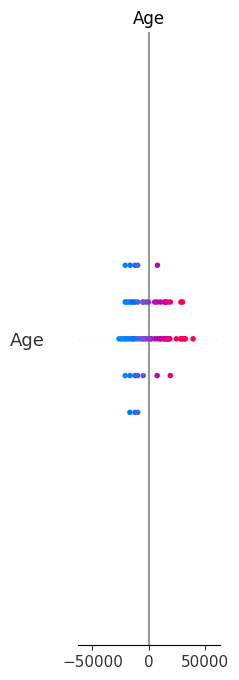

Neural Network Performance:
MSE: 481845104.04
MAE: 14169.30
R-squared Score (R²): 0.80


{'mse': 481845104.0444206,
 'mae': 14169.298020833334,
 'r2': 0.7985170615663767,
 'predictions': array([106932.875,  98061.47 , 113649.484,  51943.863, 132554.3  ,
         43521.742, 132450.33 , 104133.84 , 124787.04 ,  97318.13 ,
         49641.723, 129165.11 ,  64165.668,  84858.71 , 112827.91 ,
         98366.234,  77843.77 ,  80210.59 ,  54347.113,  92020.875,
        123131.84 , 107183.92 , 132378.97 ,  93505.43 ,  81796.73 ,
         56879.31 ,  63902.066,  41255.996, 106440.66 , 166816.73 ,
         67535.516, 101298.7  ,  72178.59 , 139044.19 , 193318.58 ,
         41364.844, 168257.34 ,  72004.625, 149537.81 ,  48639.945,
        103378.81 , 131116.98 , 134256.97 , 196019.73 ,  67317.69 ,
        136810.3  , 112105.02 ,  76995.84 ,  49391.125,  67317.69 ,
         50815.504,  94264.71 ,  55227.76 ,  96996.82 , 153878.17 ,
        153367.11 , 159725.94 ,  64909.99 ,  43860.7  ,  96826.05 ,
        106050.625,  53836.05 , 131116.98 ,  77843.77 ,  74676.95 ,
         67317.69 ,

In [7]:
#use the test dataset to predict salaries based on the trained model for a first fast evaluation.

evaluation.evaluate_NN_model(normalized_X_test_nn, y_test, nn_model)

In [8]:
evaluation.calculate_metrics(normalized_X_test_nn, y_test, nn_model)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 

{'mse': {'mean': 476386333.5521777,
  'ci_lower': 230268175.4352245,
  'ci_upper': 835688662.9102418},
 'mae': {'mean': 14115.861251822917,
  'ci_lower': 11114.434106770832,
  'ci_upper': 17410.620828125},
 'r2': {'mean': 0.8027373099276365,
  'ci_lower': 0.6941397740160998,
  'ci_upper': 0.8866054478891359}}

### Models Comparison against dummy regressor

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


<Figure size 1200x600 with 0 Axes>

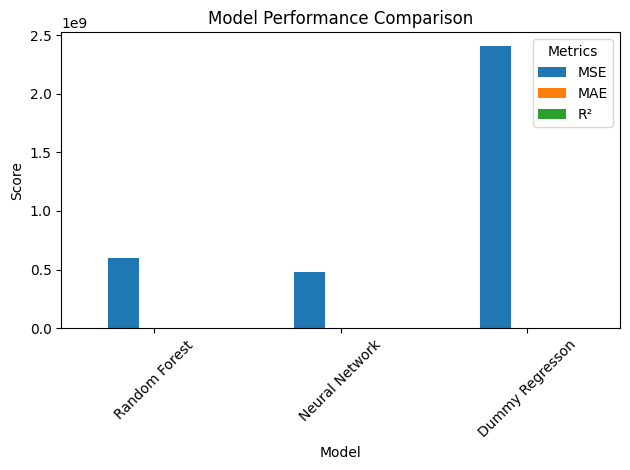

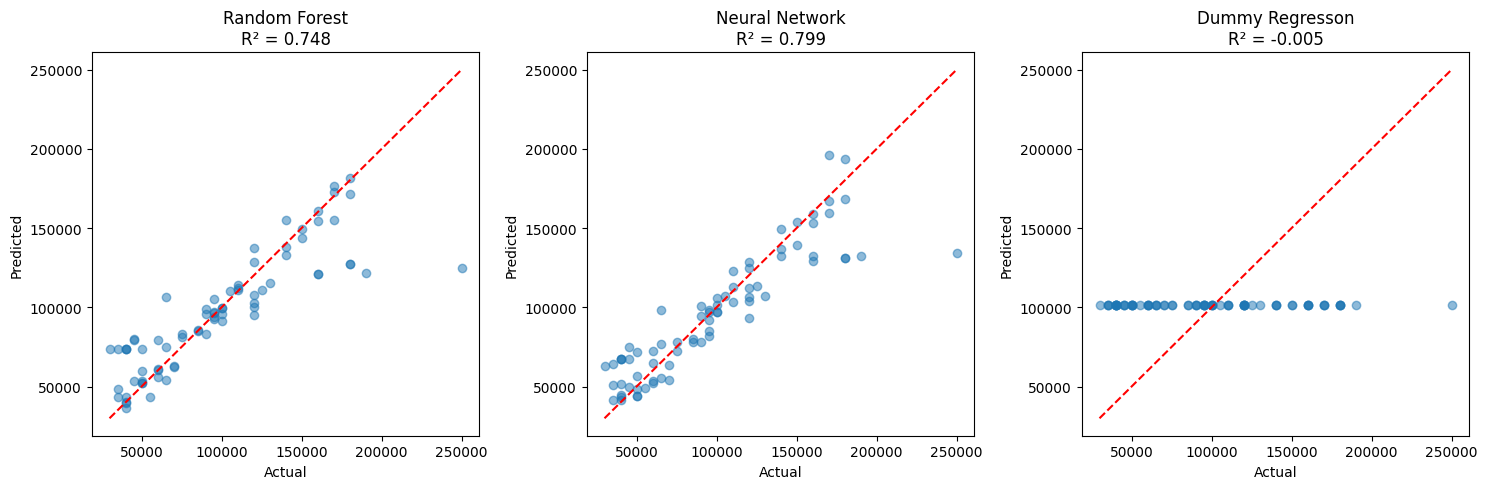

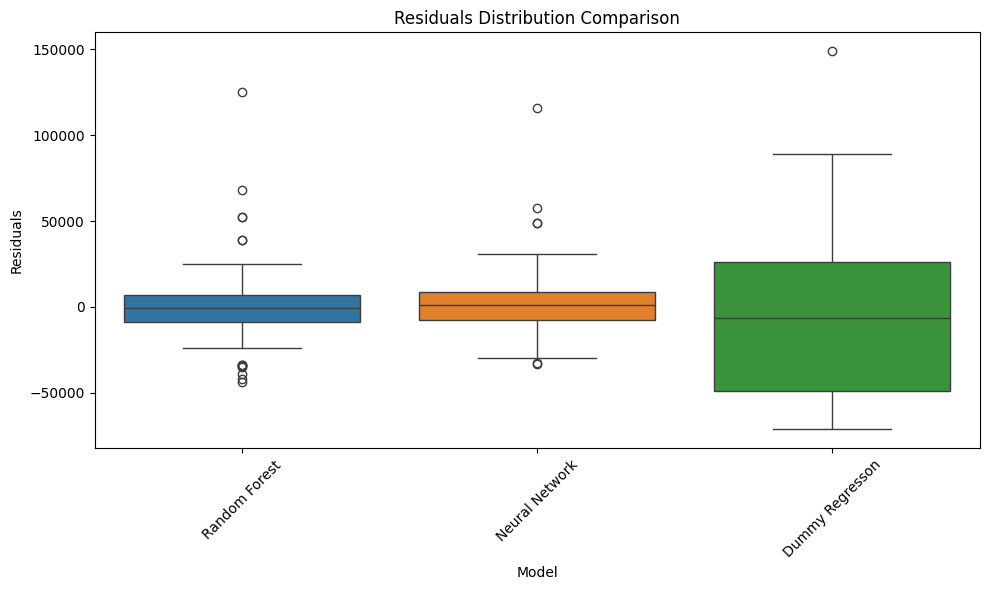


Model Performance Summary:
--------------------------------------------------

Random Forest:
MSE: 602275408.43
MAE: 14683.52
R²:  0.75

Neural Network:
MSE: 481845104.04
MAE: 14169.30
R²:  0.80

Dummy Regresson:
MSE: 2402828156.91
MAE: 40833.34
R²:  -0.00


In [9]:
models_data = {
    'Random Forest': (rf_model, normalized_X_test, y_test),
    'Neural Network': (nn_model, normalized_X_test_nn, y_test),
    'Dummy Regresson': (dummy, normalized_X_test, y_test)
}

comparison_results = model_compare.compare_models(models_data, y_test)